In [37]:
import pandas as pd
import numpy as np
import yfinance as yf
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
"""
read_data_function() function reads data from yfinance and adjust it to pandas DataFrame format
"""
def read_data_function():
    ticker= "^GSPC"
    start_date = "2020-01-01"
    stop_date = "2025-01-01"
    data_frame = yf.download(ticker, start = start_date, end = stop_date, interval = "1d")
    data_frame = pd.DataFrame(data_frame)
    return data_frame

In [38]:
read_data_function()

/tmp/ipython-input-3369913485.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_frame = yf.download(ticker, start = start_date, end = stop_date, interval = "1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2020-01-02,3257.850098,3258.139893,3235.530029,3244.669922,3459930000
2020-01-03,3234.850098,3246.149902,3222.340088,3226.360107,3484700000
2020-01-06,3246.280029,3246.840088,3214.639893,3217.550049,3702460000
2020-01-07,3237.179932,3244.909912,3232.429932,3241.860107,3435910000
2020-01-08,3253.050049,3267.070068,3236.669922,3238.590088,3726840000
...,...,...,...,...,...
2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1757720000
2024-12-26,6037.589844,6049.750000,6007.370117,6024.970215,2904530000


In [39]:
"""
data_prep_function(sequence_dataset, window_size) function turns data (sequence_dataset parameter) into windows with the size given in window_size parameter
"""
def data_prep_function(sequence_dataset, window_size):
    for i in range(1, window_size + 1):
        sequence_dataset[f"Open-{i}"] = sequence_dataset["Open"].shift(i)

    sequence_dataset = sequence_dataset.drop(["Close", "High","Low", "Volume"], axis = 1)
    sequence_dataset.dropna(inplace = True)
    return sequence_dataset

In [40]:
"""
feature_target_modeling(dataset, window_size) function divide data into features and targets, create train and test sets and transform them into torch.tensor format, which enables model to correctly process data
"""
def feature_target_modeling(dataset, window_size):
    X = dataset[:, 1:]
    y = dataset[:,0]
    X = np.flip(X, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1)
    X_train = np.reshape(X_train, (X_train.shape[0], window_size, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], window_size, 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], 1))
    X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype = torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype = torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype = torch.float32)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor

In [41]:
"""
CustomLSTMDataSet, inheriting TensorDataSet object, helps with getting correct format of values from target and feature
"""
class CustomLSTMDataSet(TensorDataset):
    def __getitem__(self, idx):
        X, y = super().__getitem__(idx)

        return X,y

In [42]:
"""
split_groups(X_train, X_test, y_train, y_test) function assigns given features and targets to train, test and validation sets and transform the following sets to DataLoader objects for further processing
"""
def split_groups(X_train, X_test, y_train, y_test):
    train_dataset = CustomLSTMDataSet(X_train, y_train)
    test_dataset = CustomLSTMDataSet(X_test, y_test)

    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_sub, val_sub = random_split(train_dataset, [train_size, val_size])
    val_loader = torch.utils.data.DataLoader(val_sub, batch_size=16, shuffle=False)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 16, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 16, shuffle = False)
    return train_loader, val_loader, test_loader

In [43]:
"""
CustomLSTM(nn.Module) is customised LSTM model taken from https://github.com/piEsposito/pytorch-lstm-by-hand/blob/master/LSTM.ipynb and additionally finetuned for our use-case. It uses only two matrix multiplications, which makes it execute faster due to vector optimization
"""
class CustomLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz, output_sz = 1):
        super().__init__()
        self.input_sz= input_sz
        self.hidden_size= hidden_sz
        self.W= nn.Parameter(torch.Tensor(input_sz, hidden_sz* 4))
        self.U= nn.Parameter(torch.Tensor(hidden_sz, hidden_sz* 4))
        self.bias= nn.Parameter(torch.Tensor(hidden_sz* 4))
        self.linear = nn.Linear(hidden_sz, output_sz)
        self.init_weights()

    def init_weights(self):
        stdv= 1.0/ math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, x,
                init_states=None):


        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _= x.size()
        hidden_seq= []
        if init_states is None:

            h_t, c_t= (torch.zeros(bs, self.hidden_size).to(x.device),
                            torch.zeros(bs, self.hidden_size).to(x.device))
        else:

             h_t, c_t= init_states

        HS= self.hidden_size
        for t in range(seq_sz):
                        x_t= x[:, t, :]
            # batch the computations into a single matrix multiplication
                        gates= x_t@ self.W+ h_t@ self.U+ self.bias
                        i_t, f_t, g_t, o_t= (
                            torch.sigmoid(gates[:, :HS]),# input
                            torch.sigmoid(gates[:, HS:HS*2]),# forget
                            torch.tanh(gates[:, HS*2:HS*3]),
                            torch.sigmoid(gates[:, HS*3:]),# output
                        )
                        c_t= f_t* c_t+ i_t* g_t
                        h_t= o_t* torch.tanh(c_t)
                        hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq= torch.cat(hidden_seq, dim=0)
            # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq= hidden_seq.transpose(0, 1).contiguous()
        output = self.linear(hidden_seq[:, -1, :])
        return output

In [44]:
"""
train_model(model: torch.nn.Module, train_dataloader : DataLoader, val_dataloader: DataLoader, epochs: int) trains the model and return validation loss and train loss for evaluation
"""
def train_model(model: torch.nn.Module, train_dataloader : DataLoader, val_dataloader: DataLoader, epochs: int):
    model.train(True)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    loss_function = torch.nn.MSELoss()
    loss_vectorize_train = np.zeros(epochs)
    loss_vectorize_val = np.zeros(epochs)

    for epoch in range(epochs):
        epoch_loss_train = 0
        for batch_idx_train, act_batch_train in enumerate(train_dataloader):
            X_trained, y_trained = act_batch_train[0], act_batch_train[1]
            optimizer.zero_grad()
            preds = model(X_trained)
            loss = loss_function(preds, y_trained)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item()
            loss_vectorize_train[epoch] = epoch_loss_train / len(train_dataloader)

        model.eval()

        with torch.no_grad():
            epoch_loss_val = 0
            for batch_idx_val, act_batch_val in enumerate(val_dataloader):
                X_validated, y_validated = act_batch_val[0], act_batch_val[1]
                preds_2 = model(X_validated)
                loss = loss_function(preds_2, y_validated)
                epoch_loss_val += loss.item()
                loss_vectorize_val[epoch] = epoch_loss_val / len(val_dataloader)

        print(f"Epoch {epoch}: Train loss {loss_vectorize_train[epoch] : .6f} || Val loss {loss_vectorize_val[epoch] : .6f}")



    return loss_vectorize_train, loss_vectorize_val, model

In [45]:
"""
Using previously mentioned functions to process data, define model and split sets. In addition, we scale our data using MinMaxScaler() (For Window Size 10).
"""
data = read_data_function()
window_data_10 = data_prep_function(data, 10)
window_data_10 = window_data_10.to_numpy()
scaler = MinMaxScaler()
normalized_data_10 = scaler.fit_transform(window_data_10)
X_train_10, X_test_10, y_train_10, y_test_10 = feature_target_modeling(normalized_data_10,10)
train_loader_10, val_loader_10, test_loader_10 = split_groups(X_train_10, X_test_10, y_train_10, y_test_10)
model_10 = CustomLSTM(1, 8)


/tmp/ipython-input-3369913485.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_frame = yf.download(ticker, start = start_date, end = stop_date, interval = "1d")
[*********************100%***********************]  1 of 1 completed


In [46]:
"""
Training and assesing model's loss (For Window Size 10)
"""
loss_train_10, loss_val_10, model_10 = train_model(model_10, train_loader_10, val_loader_10,4)

Epoch 0: Train loss  0.440502 || Val loss  0.206266
Epoch 1: Train loss  0.047861 || Val loss  0.030614
Epoch 2: Train loss  0.018032 || Val loss  0.015982
Epoch 3: Train loss  0.006714 || Val loss  0.002969


In [47]:
"""
Evaluating model on test set + Adjusting Tensor Size for matplotlib.pyplot visualizations (For Window Size 10)
"""
test_predictions_10 = model_10(X_test_10).detach().numpy().flatten()

final_var_10 = np.zeros((X_test_10.shape[0], 11))
final_var_10[:, 0] = test_predictions_10
final_var_10 = scaler.inverse_transform(final_var_10)

test_predictions_10 = final_var_10[:, 0]
test_predictions_10

array([4238.64110252, 3209.95480225, 5152.44663061, 3269.34599904,
       4033.92681959, 3140.46808797, 4342.00107173, 4148.13145563,
       4431.46634694, 5532.15373216, 4453.74023896, 4147.43437772,
       4491.79516898, 4483.75624642, 5453.92796104, 3426.63317447,
       4933.67532666, 4425.86323511, 4474.65393477, 5028.6336845 ,
       5450.85801089, 4342.13396707, 4333.0884812 , 4043.58063555,
       5582.5154041 , 3389.37063571, 4314.57957967, 4357.7769026 ,
       3341.3279534 , 5262.61210878, 4501.52392252, 3989.13180947,
       4747.84553871, 5400.16715698, 3753.11965641, 4201.34822649,
       5002.24456505, 4311.57279442, 4469.80087788, 3895.82094627,
       4023.69070925, 4151.86158091, 3944.77306735, 4039.69293762,
       4112.14964755, 4252.49798814, 4195.12229514, 4683.79655288,
       5225.28323555, 5240.14668447, 4947.49644147, 4160.11354352,
       4330.75319095, 3990.42861438, 3985.19996402, 5356.46157165,
       3566.3346974 , 4955.70991652, 4606.96810715, 3590.69189

In [48]:
final_var_10_2 = np.zeros((X_test_10.shape[0],11))
final_var_10_2[:, 0] = y_test_10.flatten()

final_var_10_2 = scaler.inverse_transform(final_var_10_2)

new_y_test_10 = final_var_10_2[:, 0]
new_y_test_10

/tmp/ipython-input-758020394.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  final_var_10_2[:, 0] = y_test_10.flatten()


array([4255.27973427, 2948.05007607, 5441.93025172, 3064.78000647,
       4048.26004556, 2812.63991783, 4493.1001242 , 4157.68022315,
       4341.74026181, 6003.97994047, 4563.87017273, 4075.28998314,
       4412.60992524, 4447.49030947, 5723.22032077, 3270.44991326,
       5084.6498605 , 4462.12011617, 4380.58011198, 5221.10008887,
       5859.430115  , 4409.58004744, 4361.26998968, 3938.67991813,
       6074.28994927, 3224.20997768, 4364.14999233, 4402.95022294,
       3153.07005223, 5637.7699789 , 4555.18986603, 3875.22998009,
       4886.66026262, 5757.73009228, 3689.05006841, 4130.54976508,
       5225.49016287, 4321.06971691, 4554.37981576, 3839.74002059,
       4022.93997512, 4122.25003259, 3960.60006405, 3987.55008331,
       4155.93017045, 4293.20991928, 4191.97989778, 4669.14003128,
       5460.73007404, 5151.14009061, 5029.02988013, 4170.16015916,
       4284.52010389, 3810.4699929 , 3992.77997885, 5727.66020222,
       3277.16995717, 5142.41993795, 4719.12995852, 3563.21992

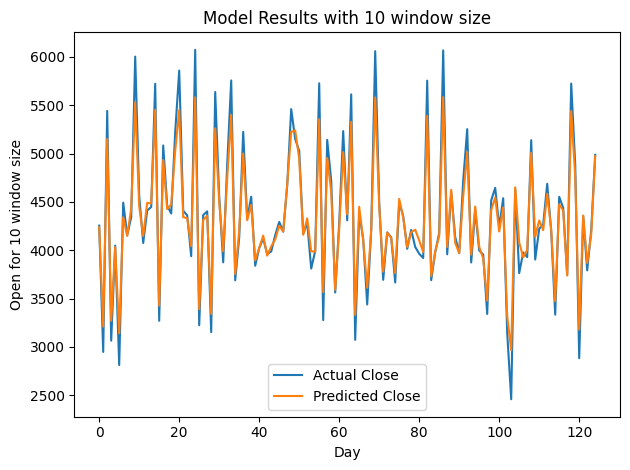

In [49]:
plt.plot(new_y_test_10, label='Actual Close')
plt.plot(test_predictions_10, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Open for 10 window size')
plt.legend()
plt.title("Model Results with 10 window size")
plt.tight_layout()
plt.show()

In [50]:
"""
Using previously mentioned functions to process data, define model and split sets. In addition, we scale our data using MinMaxScaler() (For Window Size 20).
"""
data_20 = read_data_function()
window_data_20 = data_prep_function(data_20, 20)
window_data_20 = window_data_20.to_numpy()
scaler_20 = MinMaxScaler()
normalized_data_20 = scaler_20.fit_transform(window_data_20)
X_train_20, X_test_20, y_train_20, y_test_20 = feature_target_modeling(normalized_data_20,20)
train_loader_20, val_loader_20, test_loader_20 = split_groups(X_train_20, X_test_20, y_train_20, y_test_20)
model_20 = CustomLSTM(1, 8)

/tmp/ipython-input-3369913485.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_frame = yf.download(ticker, start = start_date, end = stop_date, interval = "1d")
[*********************100%***********************]  1 of 1 completed


In [51]:
"""
Training and assesing model's loss (For Window Size 20)
"""
loss_train_20, loss_val_20, model_20 = train_model(model_20, train_loader_20, val_loader_20,4)

Epoch 0: Train loss  0.229221 || Val loss  0.129179
Epoch 1: Train loss  0.038380 || Val loss  0.011882
Epoch 2: Train loss  0.007408 || Val loss  0.003759
Epoch 3: Train loss  0.002045 || Val loss  0.001445


In [52]:
"""
Evaluating model on test set + Adjusting Tensor Size for matplotlib.pyplot visualizations (For Window Size 20)
"""
test_predictions_20 = model_20(X_test_20).detach().numpy().flatten()

final_var_20 = np.zeros((X_test_20.shape[0], 21))
final_var_20[:, 0] = test_predictions_20
final_var_20 = scaler_20.inverse_transform(final_var_20)

test_predictions_20 = final_var_20[:, 0]
test_predictions_20

array([3389.9702495 , 3548.88046864, 4423.53994393, 3819.32734244,
       4801.56694961, 5887.21361667, 4512.26603128, 3970.42118777,
       4163.53191943, 3417.0623332 , 4429.73983957, 3437.39769659,
       3905.9129546 , 4174.9900103 , 3958.75492439, 4070.20860437,
       5712.09560022, 5782.07710625, 4468.157232  , 4709.79626862,
       3912.8332471 , 3487.78381946, 4538.21231722, 4183.17586485,
       4321.06337778, 4510.87617701, 4317.28344506, 4172.24346899,
       3956.33348989, 3945.48644588, 4292.13702151, 3879.12752632,
       4356.31482752, 3993.3557077 , 4635.90057616, 4522.36788791,
       3870.37239525, 3887.36160354, 3212.05780866, 4837.03800493,
       4165.97044695, 3400.27190192, 4542.62638935, 5427.18294471,
       3966.59190039, 3952.28889848, 3987.59208005, 4376.95367676,
       3841.37710094, 4663.34516077, 5601.30639693, 4236.67257623,
       4018.13332972, 4156.74440907, 3115.51840385, 3972.51140272,
       4593.46938238, 3040.61637448, 3802.70003057, 4132.52610

In [53]:
final_var_20_2 = np.zeros((X_test_20.shape[0],21))
final_var_20_2[:, 0] = y_test_20.flatten()

final_var_20_2 = scaler_20.inverse_transform(final_var_20_2)

new_y_test_20 = final_var_20_2[:, 0]
new_y_test_20

/tmp/ipython-input-2019362153.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  final_var_20_2[:, 0] = y_test_20.flatten()


array([3218.58009435, 3564.73995338, 4284.52010389, 3840.27001714,
       4690.5699134 , 6063.79008584, 4406.75007865, 4049.27000482,
       4168.60990225, 3323.169968  , 4524.41995488, 3370.34011433,
       3956.23002623, 4098.45022139, 3999.53002043, 3927.75997413,
       5778.35988563, 5976.75971578, 4382.43996748, 4703.95996737,
       3913.13990252, 3435.94999775, 4610.62012529, 4206.81980137,
       4232.41992551, 4452.80997161, 4128.16987452, 4241.00967321,
       3957.17987696, 4036.08008625, 4081.27004681, 3915.54005566,
       4337.3599229 , 3954.16992214, 4336.1899006 , 4532.41993708,
       3823.37012267, 3960.60006405, 2865.86008465, 4796.2798887 ,
       4190.74014505, 3288.2600389 , 4402.95022294, 5424.08016692,
       3878.9298813 , 4002.04008955, 4069.3798763 , 4509.54971403,
       3687.0100005 , 4380.58011198, 5557.47991533, 4173.39990744,
       4081.14994293, 4226.70995407, 2795.63989906, 4074.28998537,
       4576.20023358, 2344.4399431 , 3817.02001228, 4157.68022

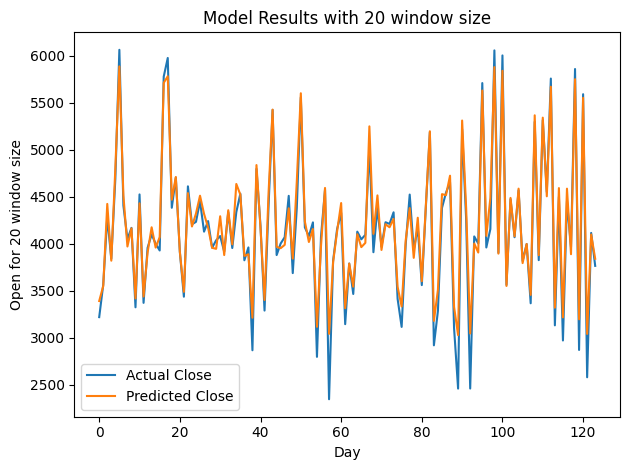

In [54]:
plt.plot(new_y_test_20, label='Actual Close')
plt.plot(test_predictions_20, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Open for 20 window size')
plt.legend()
plt.title("Model Results with 20 window size")
plt.tight_layout()
plt.show()

In [55]:
"""
Using previously mentioned functions to process data, define model and split sets. In addition, we scale our data using MinMaxScaler() (For Window Size 50).
"""
data_50 = read_data_function()
window_data_50 = data_prep_function(data_50, 50)
window_data_50 = window_data_50.to_numpy()
scaler_50 = MinMaxScaler()
normalized_data_50 = scaler_50.fit_transform(window_data_50)
X_train_50, X_test_50, y_train_50, y_test_50 = feature_target_modeling(normalized_data_50,50)
train_loader_50, val_loader_50, test_loader_50 = split_groups(X_train_50, X_test_50, y_train_50, y_test_50)
model_50 = CustomLSTM(1, 8)

/tmp/ipython-input-3369913485.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_frame = yf.download(ticker, start = start_date, end = stop_date, interval = "1d")
[*********************100%***********************]  1 of 1 completed


In [56]:
"""
Training and assesing model's loss (For Window Size 50)
"""
loss_train_50, loss_val_50, model_50 = train_model(model_50, train_loader_50, val_loader_50,4)

Epoch 0: Train loss  0.113914 || Val loss  0.018850
Epoch 1: Train loss  0.015337 || Val loss  0.005535
Epoch 2: Train loss  0.003172 || Val loss  0.001776
Epoch 3: Train loss  0.002082 || Val loss  0.001474


In [57]:
"""
Evaluating model on test set + Adjusting Tensor Size for matplotlib.pyplot visualizations (For Window Size 50)
"""
test_predictions_50 = model_50(X_test_50).detach().numpy().flatten()

final_var_50 = np.zeros((X_test_50.shape[0], 51))
final_var_50[:, 0] = test_predictions_50
final_var_50 = scaler_50.inverse_transform(final_var_50)

test_predictions_50 = final_var_50[:, 0]
test_predictions_50

array([3201.19055868, 5538.5270483 , 4128.38483895, 3900.61264944,
       5335.39120876, 5557.9275032 , 4025.86638926, 5828.98848023,
       4473.27743795, 3914.6469175 , 4452.47286573, 5705.80944713,
       4665.09181751, 4390.29143291, 3896.78189047, 5021.35907991,
       4686.00687171, 5271.68634713, 4438.94697326, 5524.77339994,
       4200.16190357, 4110.20579858, 4520.06746287, 4797.67427093,
       4738.56210907, 3922.22127239, 5735.9157872 , 4067.8381093 ,
       5832.36791577, 3992.98532139, 4564.17580936, 4828.81728516,
       5519.50286605, 5742.80913839, 5201.10851009, 3445.18282756,
       5542.00904191, 3955.1623356 , 4509.85014352, 4520.19084951,
       4744.83943266, 4650.03796829, 4572.77325457, 4443.34338639,
       4356.13597349, 3881.42614018, 3404.67103182, 3806.40944047,
       3396.90106948, 4501.48294457, 4092.22259205, 5308.42183251,
       4754.59648588, 4037.680943  , 5600.69806683, 4473.73340252,
       4323.40591275, 4497.08607865, 3854.60901625, 3717.03042

In [58]:
final_var_50_2 = np.zeros((X_test_50.shape[0],51))
final_var_50_2[:, 0] = y_test_50.flatten()

final_var_50_2 = scaler_50.inverse_transform(final_var_50_2)

new_y_test_50 = final_var_50_2[:, 0]
new_y_test_50

/tmp/ipython-input-4143826222.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  final_var_50_2[:, 0] = y_test_50.flatten()


array([2776.99000848, 5471.08006233, 4098.45022139, 3909.04007012,
       5221.10008887, 5206.42002193, 4022.93997512, 5841.99999757,
       4550.16021908, 4034.43994953, 4401.30997302, 5829.81007677,
       4655.24013013, 4437.76993264, 3879.34011358, 4973.04970134,
       4679.41983634, 5175.1400372 , 4328.18018331, 5314.66021573,
       4274.45016931, 4176.79983195, 4462.64015123, 4356.31980826,
       4678.4800603 , 3957.17987696, 5857.81974955, 4138.77976714,
       6057.5897374 , 4055.1498876 , 4478.87013549, 4778.1402415 ,
       5376.97997743, 5826.75008811, 5130.99025997, 3254.86006795,
       5293.12981311, 3876.73993824, 4385.6299083 , 4437.58994662,
       4675.77981727, 4566.39020334, 4498.02970345, 4563.87017273,
       4321.35995851, 3686.43993159, 3046.60011711, 3862.95991458,
       3018.59010473, 4432.75002078, 4127.95015574, 5168.97998752,
       4504.72993757, 4126.70021512, 5602.89004747, 4363.14003307,
       4409.58004744, 4555.18986603, 3823.37012267, 3703.11014

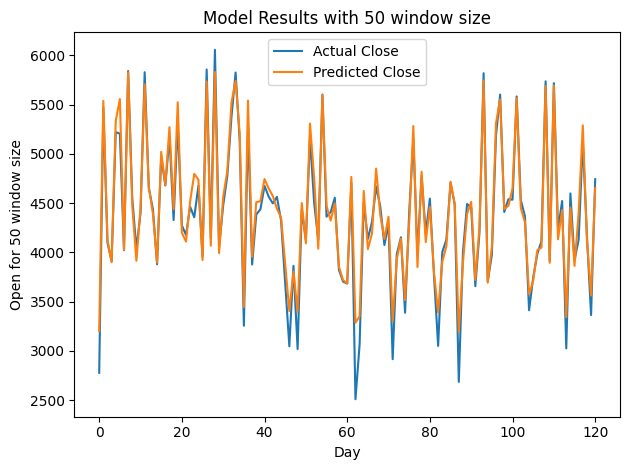

In [59]:
plt.plot(new_y_test_50, label='Actual Close')
plt.plot(test_predictions_50, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Open for 50 window size')
plt.title("Model Results with 50 window size")
plt.tight_layout()
plt.legend()
plt.show()

/tmp/ipython-input-1727868917.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0,1].legend()
/tmp/ipython-input-1727868917.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0,2].legend()
/tmp/ipython-input-1727868917.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1,1].legend()
/tmp/ipython-input-1727868917.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1,2].legend()
/tmp/ipython-input-1727868917.py:69: UserWarning: No artists with labels found to put in

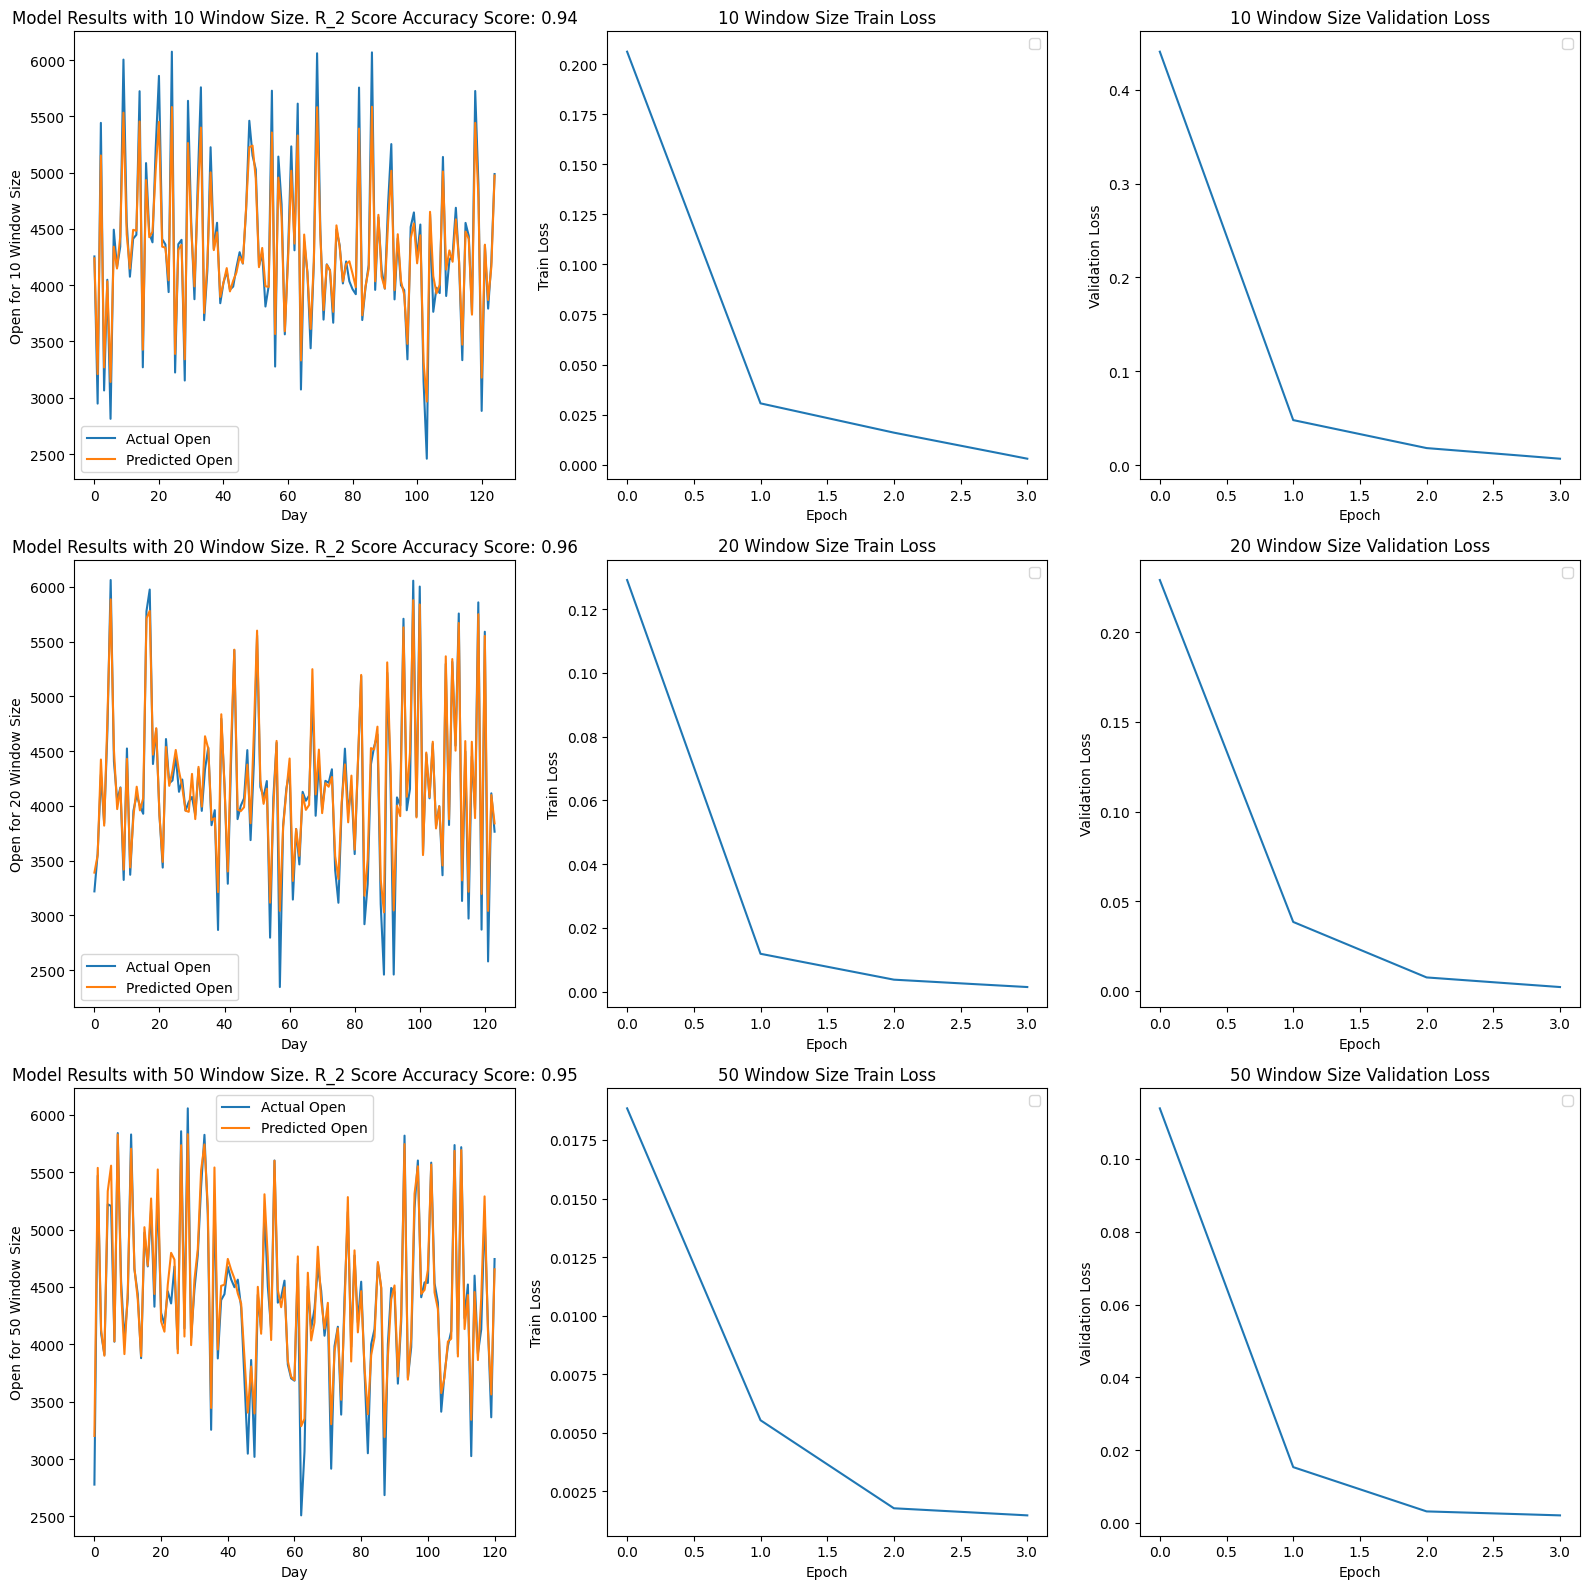

<Figure size 640x480 with 0 Axes>

In [60]:
"""
Extended visualization gird with validation adn train loss for every window size, assesing accuracy using R squared scored and visualization of results using test sets
"""
predictions_10, actual_10, loss_vec_10_val, loss_vec_10_train = test_predictions_10, new_y_test_10, loss_train_10, loss_val_10
predictions_20, actual_20, loss_vec_20_val, loss_vec_20_train = test_predictions_20, new_y_test_20, loss_train_20, loss_val_20
predictions_50, actual_50, loss_vec_50_val, loss_vec_50_train = test_predictions_50, new_y_test_50, loss_train_50, loss_val_50

accuracy_10 = r2_score(actual_10, predictions_10)
accuracy_20 = r2_score(actual_20, predictions_20)
accuracy_50 = r2_score(actual_50, predictions_50)

fig, axes = plt.subplots(3,3, figsize = (16,16))

axes[0,0].plot(actual_10, label='Actual Open')
axes[0,0].plot(predictions_10, label='Predicted Open')
axes[0,0].set_title(f"Model Results with 10 Window Size. R_2 Score Accuracy Score: {accuracy_10:.2f}")
axes[0,0].set_xlabel('Day')
axes[0,0].set_ylabel('Open for 10 Window Size')
axes[0,0].legend()


axes[0,1].plot(loss_vec_10_train)
axes[0,1].set_title("10 Window Size Train Loss")
axes[0,1].set_xlabel("Epoch")
axes[0,1].set_ylabel("Train Loss")
axes[0,1].legend()


axes[0,2].plot(loss_vec_10_val)
axes[0,2].set_title("10 Window Size Validation Loss")
axes[0,2].set_xlabel("Epoch")
axes[0,2].set_ylabel("Validation Loss")
axes[0,2].legend()


axes[1,0].plot(actual_20, label='Actual Open')
axes[1,0].plot(predictions_20, label='Predicted Open')
axes[1,0].set_title(f"Model Results with 20 Window Size. R_2 Score Accuracy Score: {accuracy_20:.2f}")
axes[1,0].set_xlabel('Day')
axes[1,0].set_ylabel('Open for 20 Window Size')
axes[1,0].legend()


axes[1,1].plot(loss_vec_20_train)
axes[1,1].set_title("20 Window Size Train Loss")
axes[1,1].set_xlabel("Epoch")
axes[1,1].set_ylabel("Train Loss")
axes[1,1].legend()


axes[1,2].plot(loss_vec_20_val)
axes[1,2].set_title("20 Window Size Validation Loss")
axes[1,2].set_xlabel("Epoch")
axes[1,2].set_ylabel("Validation Loss")
axes[1,2].legend()

axes[2,0].plot(actual_50, label='Actual Open')
axes[2,0].plot(predictions_50, label='Predicted Open')
axes[2,0].set_title(f"Model Results with 50 Window Size. R_2 Score Accuracy Score: {accuracy_50:.2f}")
axes[2,0].set_xlabel('Day')
axes[2,0].set_ylabel('Open for 50 Window Size')
axes[2,0].legend()


axes[2,1].plot(loss_vec_50_train)
axes[2,1].set_title("50 Window Size Train Loss")
axes[2,1].set_xlabel("Epoch")
axes[2,1].set_ylabel("Train Loss")
axes[2,1].legend()


axes[2,2].plot(loss_vec_50_val)
axes[2,2].set_title("50 Window Size Validation Loss")
axes[2,2].set_xlabel("Epoch")
axes[2,2].set_ylabel("Validation Loss")
axes[2,2].legend()

plt.tight_layout()
plt.show()
plt.savefig("results.png")






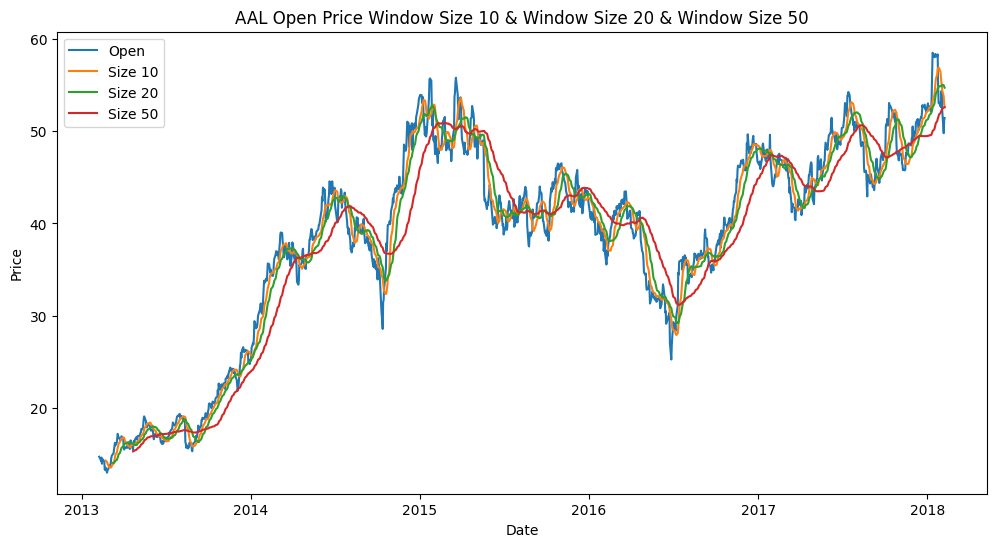

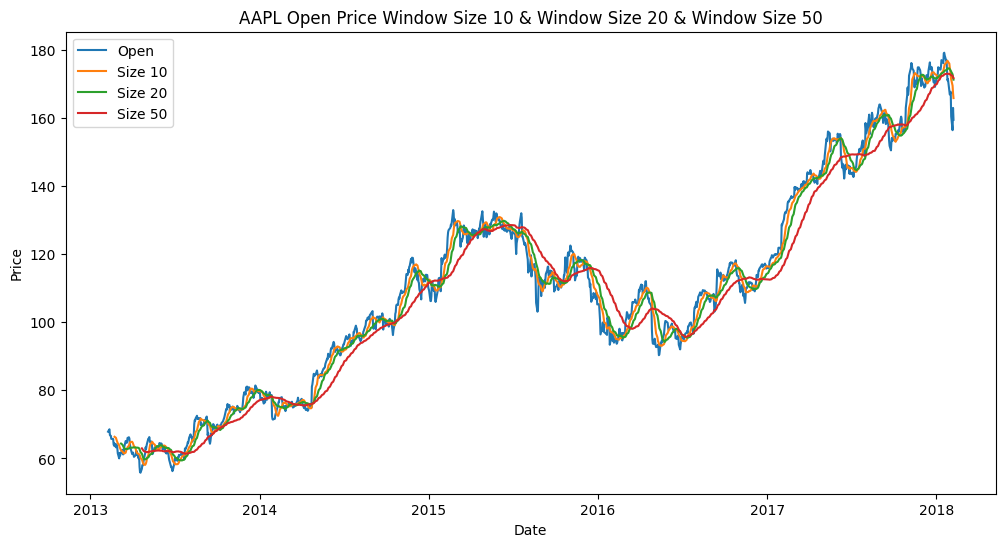

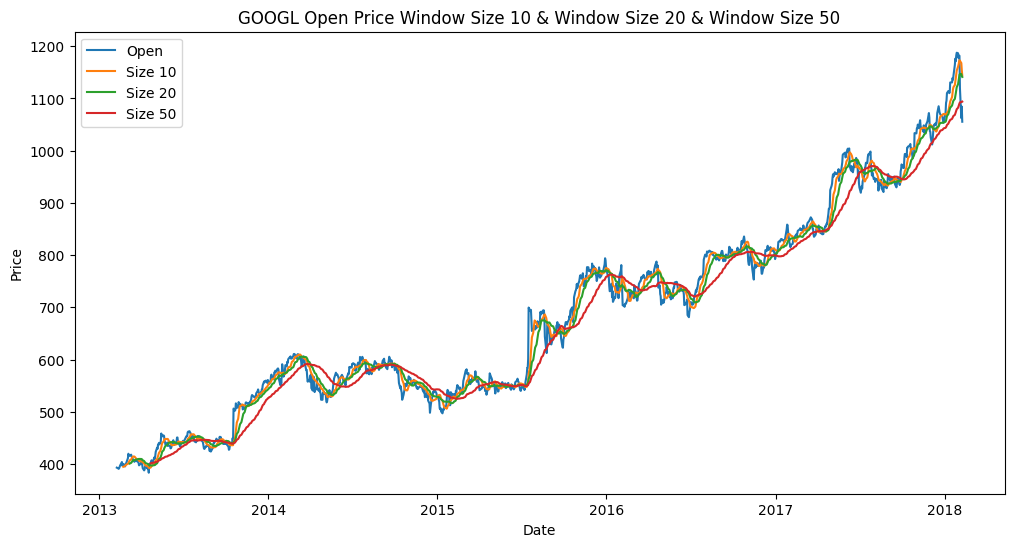

In [61]:
"""
Using all_stocks_5yr.csv dataset to visualize stock data for a given window size
"""
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('/content/all_stocks_5yr.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['Name', 'date'])
df['MA10'] = df.groupby('Name')['open'].transform(lambda x: x.rolling(window=10).mean())
df['MA20'] = df.groupby('Name')['open'].transform(lambda x: x.rolling(window=20).mean())
df['MA50'] = df.groupby('Name')['open'].transform(lambda x: x.rolling(window=50).mean())

tickers = ['AAL', 'AAPL', 'GOOGL']

for ticker in tickers:

  sub = df[df['Name'] == ticker]
  plt.figure(figsize=(12,6))
  plt.plot(sub['date'], sub['close'], label='Open')
  plt.plot(sub['date'], sub['MA10'], label='Size 10')
  plt.plot(sub['date'], sub['MA20'], label='Size 20')
  plt.plot(sub['date'], sub['MA50'], label='Size 50')
  plt.title(f'{ticker} Open Price Window Size 10 & Window Size 20 & Window Size 50')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.show()